In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
import pandas as pd
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Set device
device = torch.device("mps" if torch.mps.is_available() else "cpu")


# 1. Build your own convolutional neural network using pytorch

In [46]:

class InceptionModule(nn.Module):
    def __init__(self, in_channels, conv1x1_out, conv3x3_out, conv5x5_out, pool_proj_out):
        super(InceptionModule, self).__init__()
        # 1x1 Convolution
        self.conv1x1 = nn.Conv2d(in_channels, conv1x1_out, kernel_size=1)

        # 3x3 Convolution
        self.conv3x3 = nn.Sequential(
            nn.Conv2d(in_channels, conv3x3_out, kernel_size=3, padding=1)
        )

        # 5x5 Convolution
        self.conv5x5 = nn.Sequential(
            nn.Conv2d(in_channels, conv5x5_out, kernel_size=5, padding=2)
        )

        # Max pooling + 1x1 Convolution
        self.pool_proj = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj_out, kernel_size=1)
        )

    def forward(self, x):
        path1 = self.conv1x1(x)
        path2 = self.conv3x3(x)
        path3 = self.conv5x5(x)
        path4 = self.pool_proj(x)
        # Concatenate along the channel dimension
        return torch.cat([path1, path2, path3, path4], dim=1)


class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        # Initial convolution and pooling layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception Modules
        self.inception3a = InceptionModule(192, 64, 128, 32, 32)
        self.inception3b = InceptionModule(256, 128, 192, 96, 64)

        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = InceptionModule(480, 192, 208, 48, 64)
        self.inception4b = InceptionModule(512, 160, 224, 64, 64)

        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)  # Adjust based on final feature map size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.pool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.pool4(x)

        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# 2. Train your model using dog heart dataset (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 

### (1) use torchvision.datasets.ImageFolder for the training dataset
### (2) use custom dataloader for test dataset (return image tensor and file name)

In [49]:
# Paths
data_dir = "dataset"
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")

# Data Transforms
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "valid": transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}
 
# Load datasets
image_datasets = {
    "train": datasets.ImageFolder('/Users/tanaygawade/Downloads/Neural/Dog_heart/Train', transform=data_transforms["train"]),
    "valid": datasets.ImageFolder('/Users/tanaygawade/Downloads/Neural/Dog_heart/Valid', transform=data_transforms["valid"]),
}

# Create dataloaders
dataloaders = {
    "train": DataLoader(image_datasets["train"], batch_size=32, shuffle=True),
    "valid": DataLoader(image_datasets["valid"], batch_size=32, shuffle=False),
}

# Dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "valid"]}

# Class names
class_names = image_datasets["train"].classes
print(f"Classes: {class_names}")

Classes: ['Large', 'Normal', 'Small']


In [51]:
# Initialize model
model = CustomCNN(num_classes=len(class_names)).to(device).float()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)


# Training and validation loop
num_epochs = 100
# Initialize lists to store metrics
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for phase in ["train", "valid"]:
        if phase == "train":
            model.train()
        else:
            model.eval()
        
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in dataloaders[phase]:
            # Convert inputs and labels to device and ensure float32
            inputs = inputs.to(device, dtype=torch.float32)
            labels = labels.to(device)
    
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == "train":
                    loss.backward()
                    optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.float() / dataset_sizes[phase]

        if phase == "train":
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
        else:
            valid_losses.append(epoch_loss)
            valid_accuracies.append(epoch_acc.item())        
        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

print("Training complete.")

Epoch 1/100
train Loss: 1.0132 Acc: 0.4243
valid Loss: 1.0005 Acc: 0.3750
Epoch 2/100
train Loss: 0.9790 Acc: 0.4321
valid Loss: 0.9740 Acc: 0.4150
Epoch 3/100
train Loss: 0.9690 Acc: 0.4486
valid Loss: 0.9447 Acc: 0.4300
Epoch 4/100
train Loss: 0.9299 Acc: 0.4750
valid Loss: 0.8925 Acc: 0.5050
Epoch 5/100
train Loss: 0.8688 Acc: 0.4957
valid Loss: 0.8106 Acc: 0.5050
Epoch 6/100
train Loss: 0.7934 Acc: 0.5407
valid Loss: 0.7477 Acc: 0.6100
Epoch 7/100
train Loss: 0.7524 Acc: 0.5950
valid Loss: 0.8025 Acc: 0.5400
Epoch 8/100
train Loss: 0.7243 Acc: 0.6336
valid Loss: 0.6990 Acc: 0.6250
Epoch 9/100
train Loss: 0.6779 Acc: 0.6550
valid Loss: 0.7790 Acc: 0.5900
Epoch 10/100
train Loss: 0.6654 Acc: 0.6657
valid Loss: 0.6765 Acc: 0.6200
Epoch 11/100
train Loss: 0.6701 Acc: 0.6707
valid Loss: 0.6622 Acc: 0.6500
Epoch 12/100
train Loss: 0.6473 Acc: 0.6786
valid Loss: 0.6443 Acc: 0.6650
Epoch 13/100
train Loss: 0.6399 Acc: 0.6886
valid Loss: 0.6237 Acc: 0.7100
Epoch 14/100
train Loss: 0.6037 Ac

In [25]:
import torch
# Save the Model
# Define the file path where the model will be saved
model_save_path = "/Users/tanaygawade/Downloads/Neural/Custom_CNN_model.pth"

# Save the entire model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved successfully at {model_save_path}")

Model saved successfully at /Users/tanaygawade/Downloads/Neural/Custom_CNN_model.pth


# 3. Evaluate your model using the developed software

In [53]:

# Define numeric class labels
class_labels = ['Large', 'Normal', 'Small']  # 0 -> Large, 1 -> Normal, 2 -> Small
label_mapping = {0: 'Large', 1: 'Normal', 2: 'Small'}

# Define a custom test dataset and DataLoader
test_dir = '/Users/tanaygawade/Downloads/Neural/Test/Test'  # Replace with your test directory
# test_transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

class CustomTestDataset(torch.utils.data.Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = [f for f in os.listdir(directory) if f.endswith('.jpg') or f.endswith('.png')]
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.images[idx])
        image = Image.open(img_name).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, self.images[idx]

test_dataset = CustomTestDataset(test_dir, transform=data_transforms["valid"])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Make predictions and save to CSV
predictions = []

model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, filenames in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get class predictions for the batch
        
        # Loop through the batch and store predictions for each image
        for i in range(len(filenames)):
            predicted_label = predicted[i].item()  # Get the prediction for each image in the batch
            predicted_class = label_mapping[predicted_label]
            
            # Save predictions
            predictions.append([filenames[i], predicted_label])  # Save filename and numeric label
            
            print(f"Image: {filenames[i]} - Predicted Label: {predicted_label} ({predicted_class})")

# Save predictions to a CSV file
results_df = pd.DataFrame(predictions, columns=["Filename", "Predicted Label"])
results_df.to_csv('/Users/tanaygawade/Downloads/test_predictions_1.csv', index=False, header=False)
print("Predictions saved to test_predictions.csv")

Image: 1804.png - Predicted Label: 2 (Small)
Image: 1810.png - Predicted Label: 0 (Large)
Image: 1838.png - Predicted Label: 1 (Normal)
Image: 1623.png - Predicted Label: 2 (Small)
Image: 1637.png - Predicted Label: 1 (Normal)
Image: 1970.png - Predicted Label: 1 (Normal)
Image: 1964.png - Predicted Label: 1 (Normal)
Image: 1794.png - Predicted Label: 1 (Normal)
Image: 1958.png - Predicted Label: 1 (Normal)
Image: 1780.png - Predicted Label: 2 (Small)
Image: 1757.png - Predicted Label: 0 (Large)
Image: 1743.png - Predicted Label: 1 (Normal)
Image: 1742.png - Predicted Label: 1 (Normal)
Image: 1756.png - Predicted Label: 0 (Large)
Image: 1781.png - Predicted Label: 0 (Large)
Image: 1959.png - Predicted Label: 0 (Large)
Image: 1795.png - Predicted Label: 1 (Normal)
Image: 1965.png - Predicted Label: 1 (Normal)
Image: 1971.png - Predicted Label: 0 (Large)
Image: 1636.png - Predicted Label: 1 (Normal)
Image: 1622.png - Predicted Label: 2 (Small)
Image: 1839.png - Predicted Label: 1 (Normal

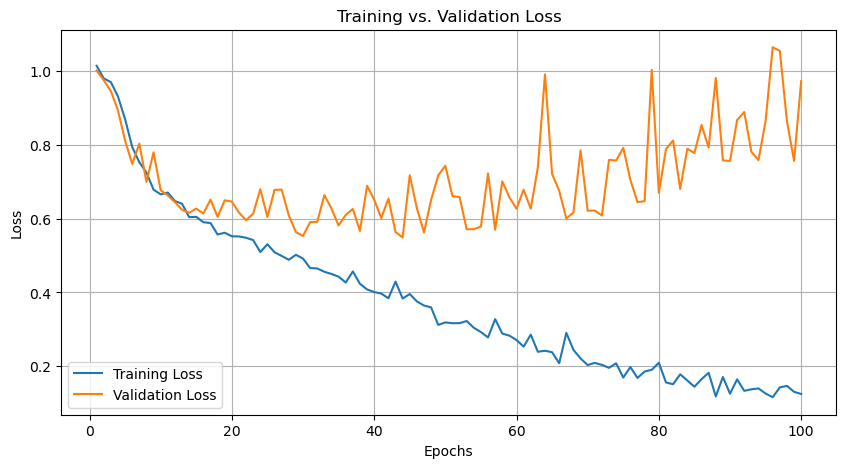

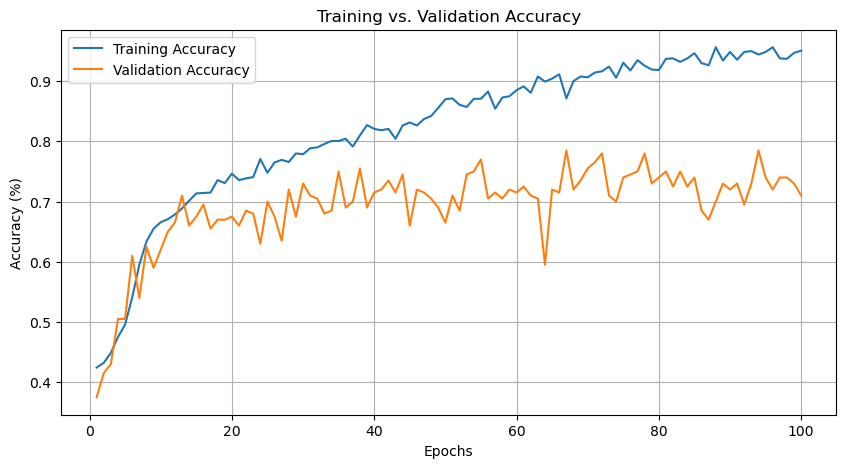

In [55]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), valid_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, num_epochs + 1), valid_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs. Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

Confusion Matrix for Validation Dataset:


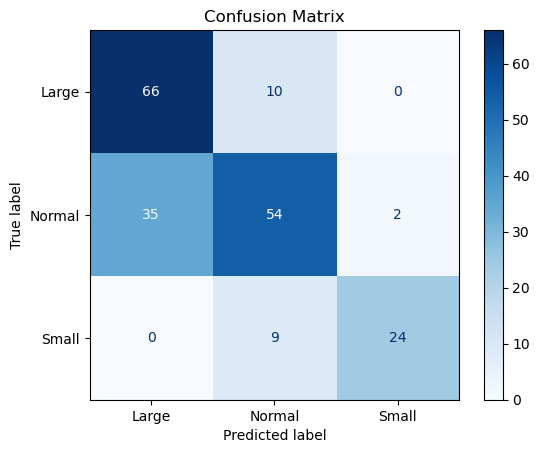

Confusion Matrix for Test Dataset:


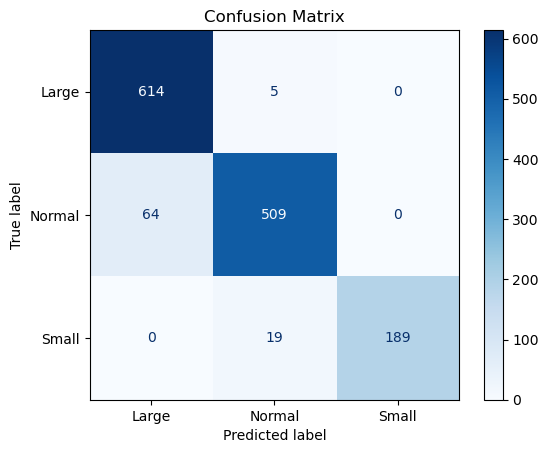

In [61]:
# Function to calculate confusion matrix
def plot_confusion_matrix(loader, model, class_names):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device, dtype=torch.float32)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Plot confusion matrix for the validation dataset
print("Confusion Matrix for Validation Dataset:")
plot_confusion_matrix(dataloaders["valid"], model, class_names)

# Plot confusion matrix for the test dataset (optional)
print("Confusion Matrix for Test Dataset:")
plot_confusion_matrix(dataloaders["train"], model, class_names)

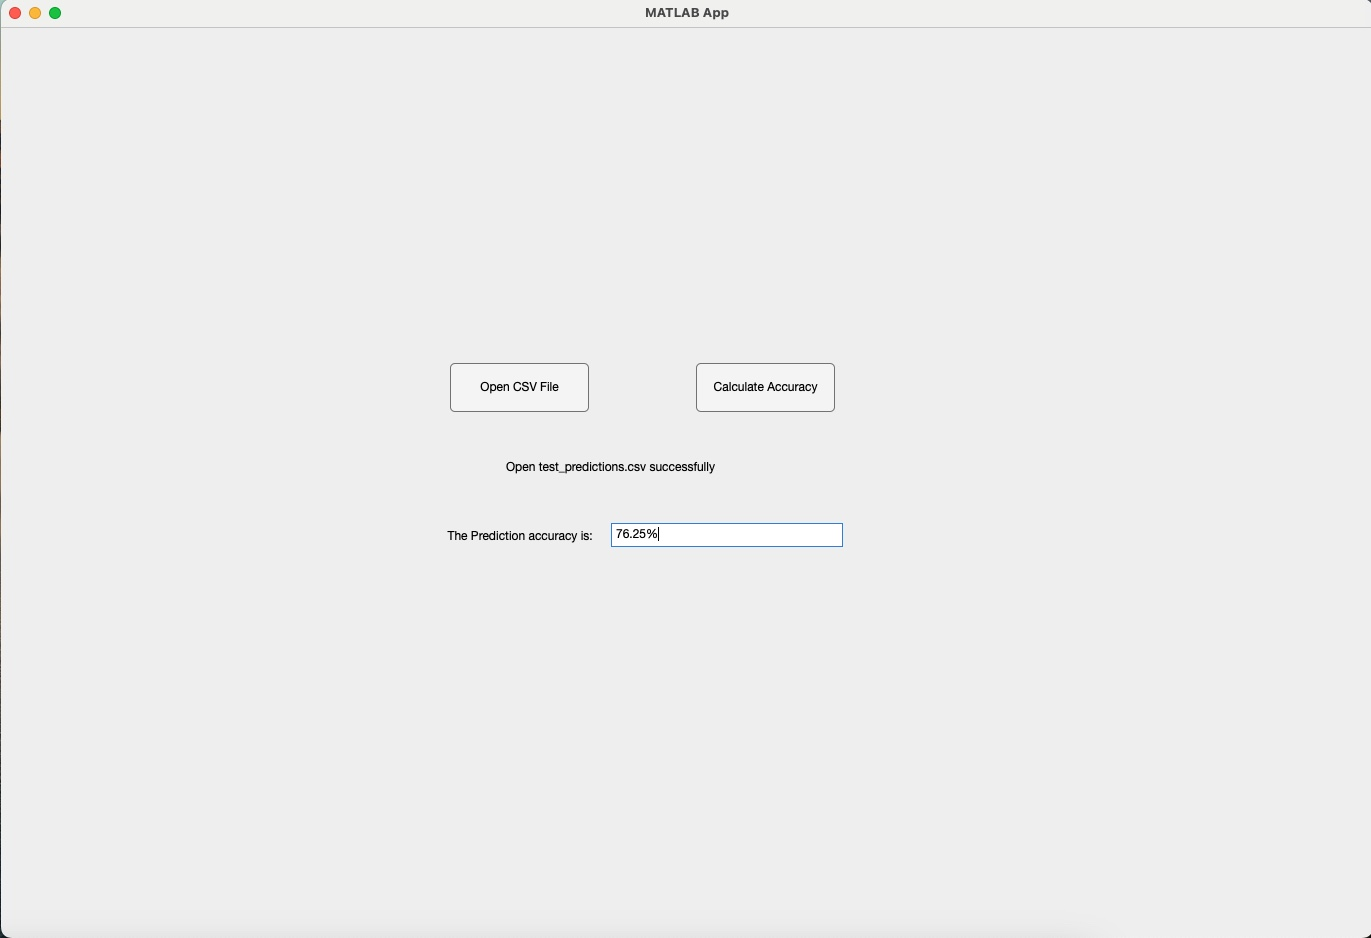

# 4. Compare results with [RVT paper](https://www.nature.com/articles/s41598-023-50063-x). Requirement: performance is better than VGG16: 75%

In [41]:
# Assuming `model` is your trained model, and device is set properly.
device = torch.device("mps" if torch.mps.is_available() else "cpu")
model.to(device)

# Define your data loaders (replace `valid_loader` and `test_loader` with your DataLoader objects)

data_transforms = {
    "test": transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "valid": transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}


image_datasets = {
    "test": datasets.ImageFolder('/Users/tanaygawade/Downloads/Neural/Test', transform=data_transforms["test"]),
    "valid": datasets.ImageFolder('/Users/tanaygawade/Downloads/Neural/Dog_heart/Valid', transform=data_transforms["valid"]),
}

# Create dataloaders
data_loader = {
    "test": DataLoader(image_datasets["test"], batch_size=32, shuffle=True),
    "valid": DataLoader(image_datasets["valid"], batch_size=32, shuffle=False),
}


valid_loader = data_loader["valid"]  # Access the validation DataLoader
test_loader = data_loader["test"]   # Access the test DataLoader

# Define thresholds for categories
class_labels = ['Small', 'Normal', 'Large']
thresholds = [8.2, 10]  # VHS thresholds: Small (<8.2), Normal (8.2–10), Large (>10)

# Function to calculate metrics
def evaluate_model(data_loader, loss_function, use_joint_loss=False):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    category_correct = [0, 0, 0]  # Small, Normal, Large
    category_total = [0, 0, 0]
    total_loss = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            # Get predictions
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            # Calculate loss
            if use_joint_loss:
                # Example: Joint loss (Cross-Entropy + MSE for key points if applicable)
                # Assuming you have additional predictions (e.g., key points) and ground truths
                # Replace `key_points_preds` and `key_points_true` with actual tensors
                # mse_loss = F.mse_loss(key_points_preds, key_points_true)
                joint_loss = loss_function(outputs, labels)  # + gamma * mse_loss
                total_loss += joint_loss.item()
            else:
                total_loss += loss_function(outputs, labels).item()

            # Append results
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            # Calculate category-wise accuracy
            for i, label in enumerate(labels.cpu().numpy()):
                category_total[label] += 1
                if preds[i].item() == label:
                    category_correct[label] += 1

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(all_labels, all_preds)

    # Calculate category-wise accuracy
    category_accuracy = [
        (category_correct[i] / category_total[i]) * 100 if category_total[i] > 0 else 0
        for i in range(len(class_labels))
    ]

    return overall_accuracy * 100, category_accuracy, total_loss / len(data_loader)

# Define loss functions
cross_entropy_loss = torch.nn.CrossEntropyLoss()

# Evaluate on validation and test sets
valid_c_accuracy, valid_category_accuracy, valid_c_loss = evaluate_model(valid_loader, cross_entropy_loss, use_joint_loss=False)
test_c_accuracy, test_category_accuracy, test_c_loss = evaluate_model(test_loader, cross_entropy_loss, use_joint_loss=False)

valid_r_accuracy, valid_category_accuracy_r, valid_r_loss = evaluate_model(valid_loader, cross_entropy_loss, use_joint_loss=True)
test_r_accuracy, test_category_accuracy_r, test_r_loss = evaluate_model(test_loader, cross_entropy_loss, use_joint_loss=True)

# Print results
print("Validation Set Results:")
print(f"Cross-Entropy Accuracy (C_Accuracy): {valid_c_accuracy:.2f}%")
print(f"Joint Loss Function Accuracy (R_Accuracy): {valid_r_accuracy:.2f}%")
print(f"Category-wise Accuracy: Small={valid_category_accuracy[0]:.2f}%, Normal={valid_category_accuracy[1]:.2f}%, Large={valid_category_accuracy[2]:.2f}%")

print("\nTest Set Results:")
print(f"Cross-Entropy Accuracy (C_Accuracy): {test_c_accuracy:.2f}%")
print(f"Joint Loss Function Accuracy (R_Accuracy): {test_r_accuracy:.2f}%")
print(f"Category-wise Accuracy: Small={test_category_accuracy[0]:.2f}%, Normal={test_category_accuracy[1]:.2f}%, Large={test_category_accuracy[2]:.2f}%")

Validation Set Results:
Cross-Entropy Accuracy (C_Accuracy): 74.50%
Joint Loss Function Accuracy (R_Accuracy): 76.00%
Category-wise Accuracy: Small=77.63%, Normal=67.03%, Large=87.88%

Test Set Results:
Cross-Entropy Accuracy (C_Accuracy): 43.00%
Joint Loss Function Accuracy (R_Accuracy): 45.25%
Category-wise Accuracy: Small=43.00%, Normal=0.00%, Large=0.00%
